## Setup environment

If TensorFlow complains about NUMA node reads from SysFs being -1, try running the following command:

`echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:01\:00.0/numa_node`


### Load libraries


In [62]:
import gc
import os
import random
from glob import glob

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import ujson
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from tensorflow import keras as tfk

### Setup tensorflow


In [63]:
tf.get_logger().setLevel("INFO")
tf.autograph.set_verbosity(0)
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # allow gpu memory growth

### Set variables


In [64]:
SEED = 42
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
INPUT_SHAPE = (28, 28, 1)
SQUARE_FIG_SIZE = (15, 15)
RECT_FIG_SIZE = (15, 10)
MAX_EPOCHS = 200
TUNED_MODEL_PATH = "tuned_model.keras"
TUNER_DIRECTORY = "mnist_bayesian"
TUNER_PROJECT_NAME = "mnist"
LOAD_TRAINED_MODEL = True
TRAINED_MODEL_PATH = "trained_model.keras"
TRAINED_FC_MODEL_PATH = "trained_fc_model.keras"
CHECKPOINT_PATH = "checkpoint.keras"

### Set seeds


In [65]:
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

### Sanity checks


In [66]:
# check that the GPU is available
# assert tf.config.list_physical_devices("GPU"), "No GPU available"
# check values
assert 0 < VALIDATION_SPLIT < 1, "validation split must be between 0 and 1"
assert 0 < TEST_SPLIT < 1, "test split must be between 0 and 1"

# check if the model has already been trained
if os.path.exists(TRAINED_MODEL_PATH) and LOAD_TRAINED_MODEL:
    print("Trained model will be loaded")

Trained model will be loaded


## Data section


### Load data


In [67]:
def split_dataset(
    ds: tf.data.Dataset,
    split: float,
) -> tuple[tf.data.Dataset, tf.data.Dataset]:
    ds_1 = ds.take(int(len(ds) * split)).cache().prefetch(tf.data.AUTOTUNE)
    ds_2 = ds.skip(int(len(ds) * split)).cache().prefetch(tf.data.AUTOTUNE)
    return ds_1, ds_2


ds_train_all, ds_test = tfds.load(
    "mnist",
    split=["train", f"train[{(TEST_SPLIT)*100}%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

ds_train, ds_validation = split_dataset(ds_train_all, VALIDATION_SPLIT)

# show size of the dataset
print(f"Training size: {len(ds_train)}")
print(f"Validation size: {len(ds_validation)}")
print(f"Test size: {len(ds_test)}")

Training size: 6000
Validation size: 54000
Test size: 54000


### Show some data


2024-02-05 09:50:03.845163: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-05 09:50:03.845189: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


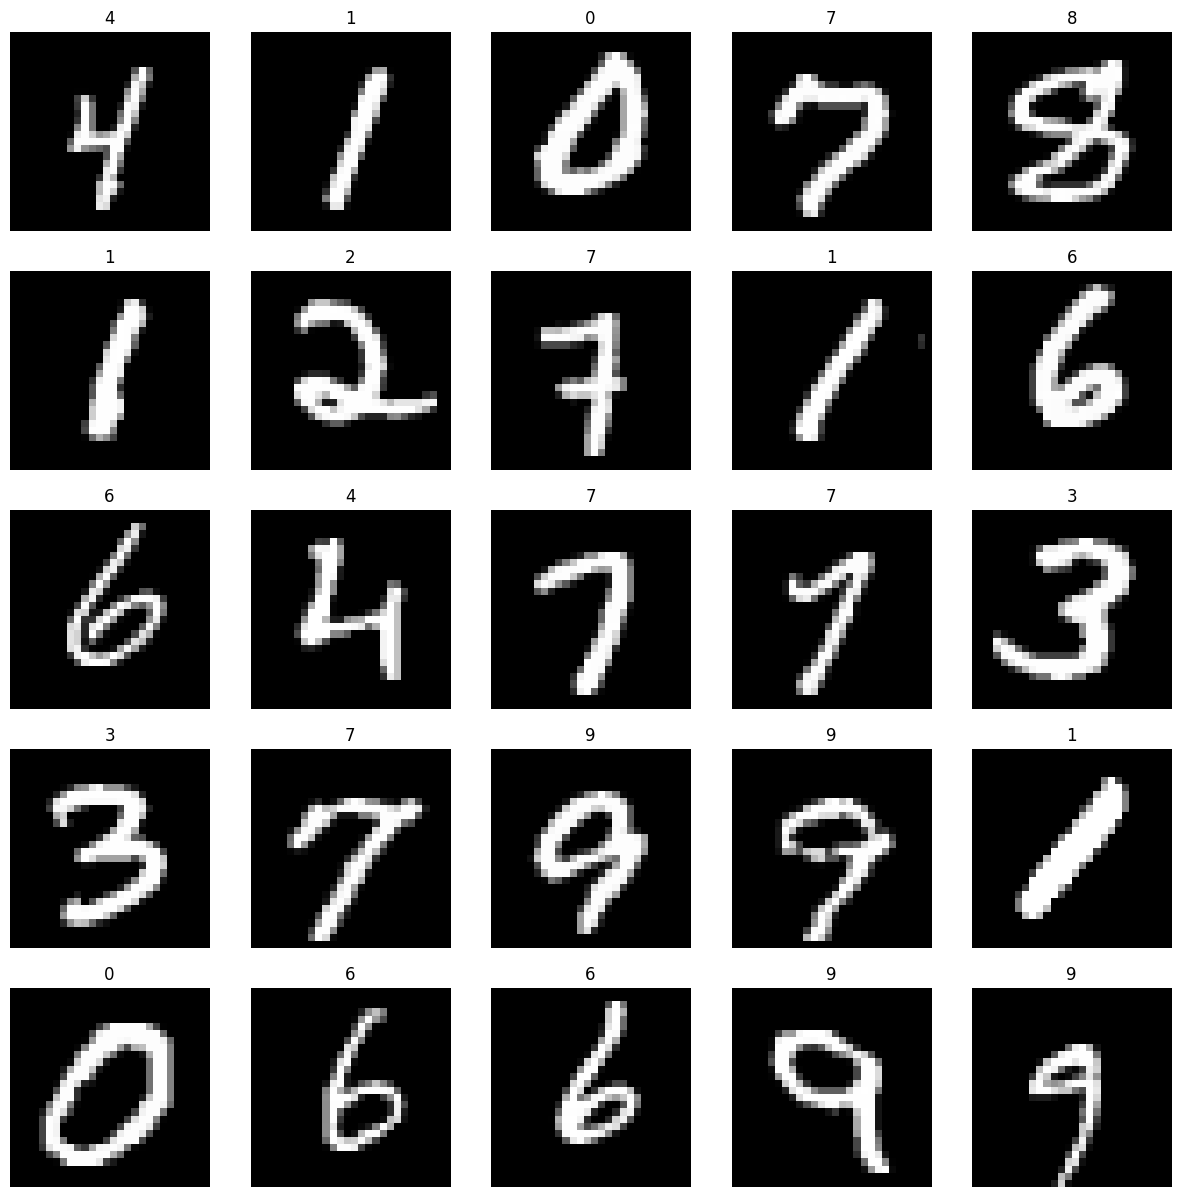

In [68]:
# take the first 25 images
images = []
labels = []

for image, label in ds_train.take(25):
    images.append(image.numpy().squeeze())
    labels.append(label.numpy())

# plot the images
plt.figure(figsize=SQUARE_FIG_SIZE)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(labels[i])
    plt.axis("off")

plt.show()

### Show distribution of source digits


Number of samples per class:
0: 613
1: 668
2: 591
3: 599
4: 550
5: 536
6: 621
7: 628
8: 602
9: 592


2024-02-05 09:50:04.797035: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


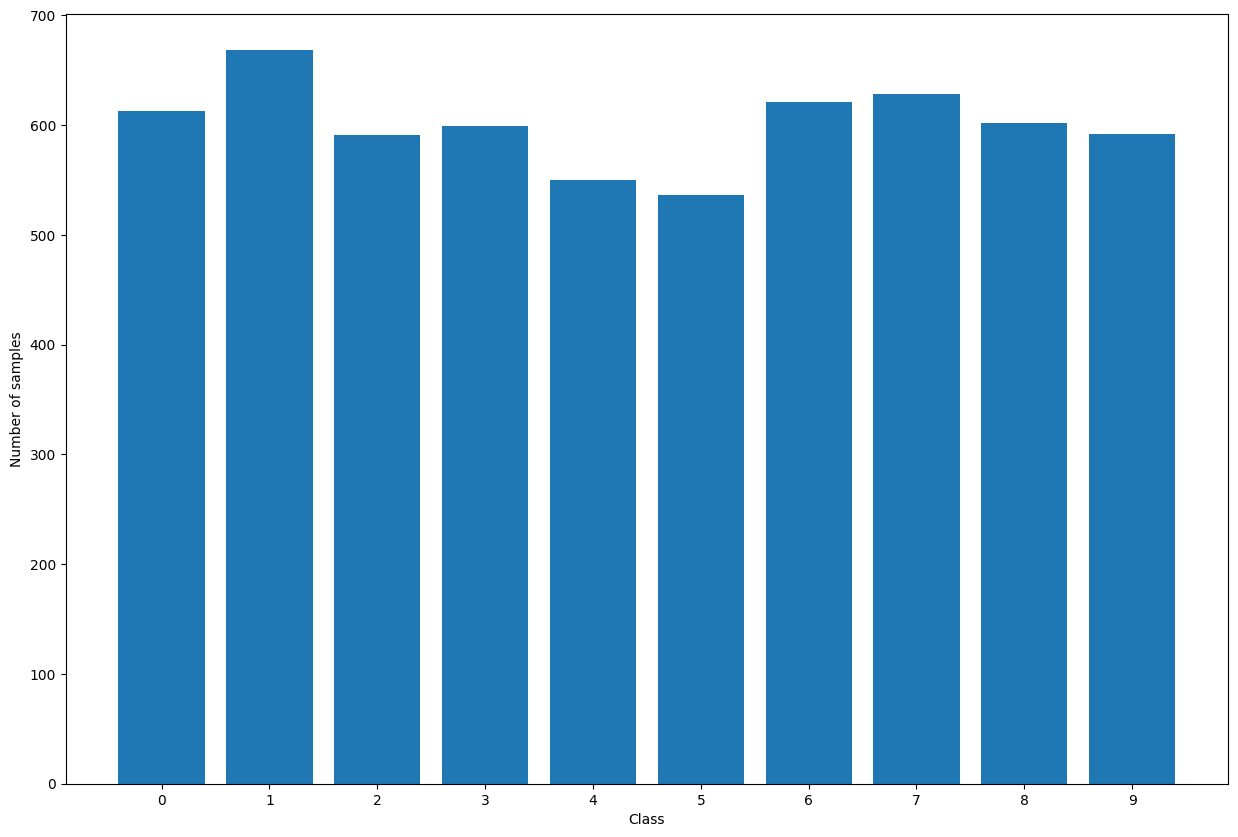

In [69]:
count = np.zeros(10, dtype=int)
for _, label in ds_train:
    count[label.numpy()] += 1

print(f"Number of samples per class:")
for i in range(10):
    print(f"{i}: {count[i]}")

# plot the distribution of the classes
plt.figure(figsize=RECT_FIG_SIZE)
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.show()

### Normalize data


In [70]:
def normalize_ds(ds: tf.data.Dataset) -> tf.data.Dataset:
    return (
        ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
        .cache()
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )


batched_ds_train = normalize_ds(ds_train)
batched_ds_validation = normalize_ds(ds_validation)
batched_ds_test = normalize_ds(ds_test)

### Compute class weights


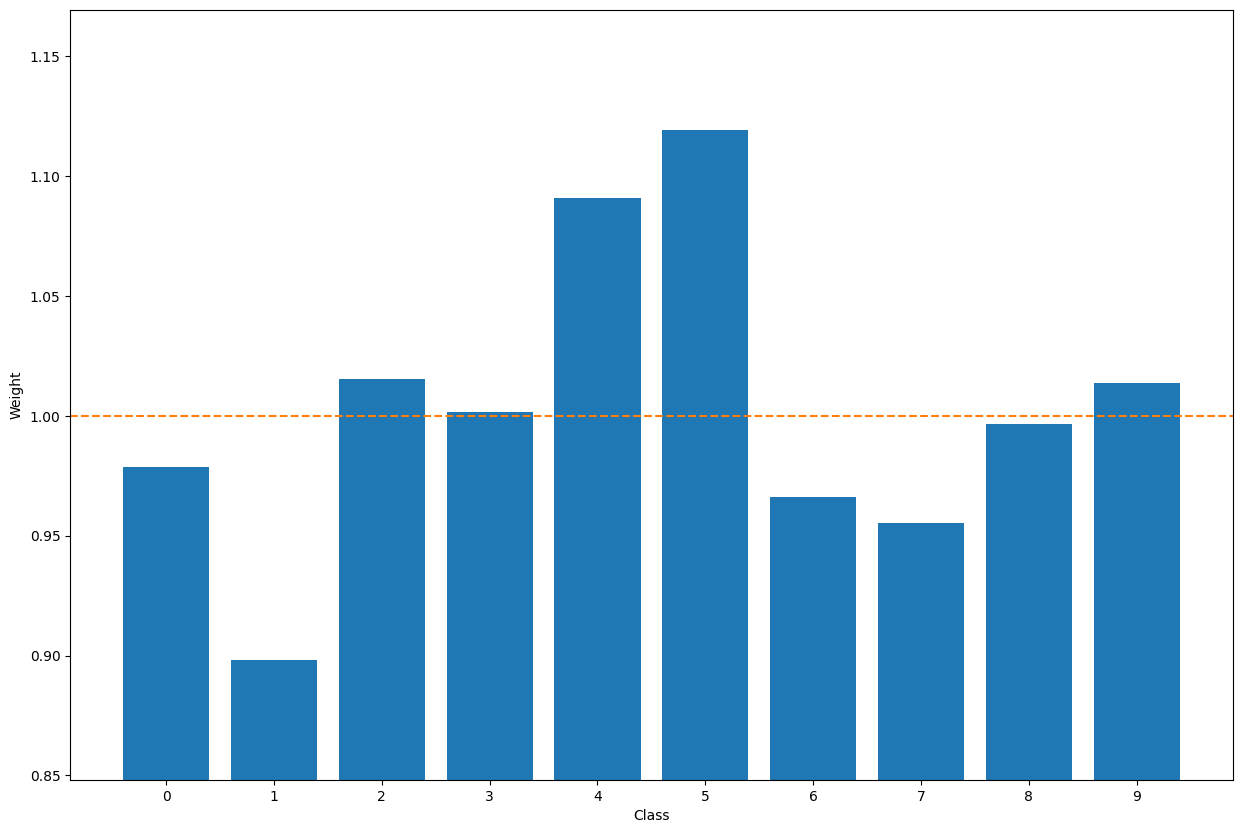

In [71]:
weights_list = 1 / (10 * count) * np.sum(count)
class_weights = dict(enumerate(weights_list))

# plot the weights
plt.figure(figsize=RECT_FIG_SIZE)
plt.bar(range(10), weights_list, color="tab:blue")
plt.axhline(1, color="tab:orange", linestyle="--")
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Weight")
plt.ylim(np.min(weights_list) - 0.05, np.max(weights_list) + 0.05)
plt.show()

## Model section


### Model creation


In [72]:
def create_model(hp: kt.HyperParameters) -> tfk.Model:
    # clear memory
    gc.collect()
    tf.keras.backend.clear_session()

    # hyperparameters

    # number of filters for each convolutional layer (4 choices each) - 4^3 = 64 combinations
    conv_filters = [
        hp.Choice("conv_1_filters", values=[32, 64, 128, 256], default=32),
        hp.Choice("conv_2_filters", values=[32, 64, 128, 256], default=64),
        hp.Choice("conv_3_filters", values=[32, 64, 128, 256], default=128),
    ]

    # size of the kernel for each convolutional layer (3 choices each) - 3^3 = 27 combinations
    conv_kernels = [
        hp.Choice("conv_1_kernels", values=[3, 5, 7], default=3),
        hp.Choice("conv_2_kernels", values=[3, 5, 7], default=5),
        hp.Choice("conv_3_kernels", values=[3, 5, 7], default=7),
    ]

    # number of units for each dense layer (4 choices each) - 4^2 = 16 combinations
    # the second dense layer can be skipped if the number of units is set to 0
    dense_units = [
        hp.Choice("dense_1_units", values=[64, 128, 256, 512], default=128),
        hp.Choice("dense_2_units", values=[0, 64, 128, 256, 512], default=0),
    ]

    # optimizers to choose from (3 choices) - 3 combinations
    learning_rate = 1e-4
    optimizers = {
        "adam": tfk.optimizers.Adam(learning_rate),
        "nadam": tfk.optimizers.Nadam(learning_rate),
        "adadelta": tfk.optimizers.Adadelta(learning_rate),
    }

    # choose the optimizer
    optimizer = hp.Choice(
        "optimizer",
        values=list(optimizers.keys()),
        default="adam",
    )

    # total number of combinations: 4^3 * 3^3 * 4^2 * 3 = 82,944
    # too many combinations to try them all, so we use a Bayesian tuner
    bias_initializer = tfk.initializers.Zeros()
    kernel_initializer = tfk.initializers.GlorotNormal(seed=SEED)
    kernel_regularizer = tfk.regularizers.L1L2(l1=0.01, l2=0.01)

    input_layer = tfk.layers.Input(shape=INPUT_SHAPE, name="input")

    # change variable names to avoid confusion
    x = input_layer

    # batch normalization
    x = tfk.layers.BatchNormalization()(x)

    # convolutional layers
    for i in range(len(conv_filters)):
        x = tfk.layers.Conv2D(
            conv_filters[i],
            kernel_size=(conv_kernels[i], conv_kernels[i]),
            activation="relu",
            padding="same",
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            name=f"conv_{i + 1}",
        )(x)
        x = tfk.layers.MaxPooling2D(pool_size=(2, 2), name=f"max_pool_{i + 1}")(x)
        x = tfk.layers.BatchNormalization(
            name=f"batch_norm_{i + 1}",
        )(x)

    # dense layers
    x = tfk.layers.Flatten(
        name="flatten",
    )(x)

    for i, units in enumerate(dense_units):
        if units > 0:
            x = tfk.layers.Dense(
                units,
                activation="relu",
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                kernel_regularizer=kernel_regularizer,
                name=f"dense_{i + 1}",
            )(x)
            x = tfk.layers.Dropout(0.5)(x)

    output_layer = tfk.layers.Dense(
        10,
        activation="softmax",
        name="dense_out",
    )(x)

    model = tfk.Model(input_layer, output_layer)

    model.compile(
        optimizer=optimizers[optimizer],
        loss=tfk.losses.SparseCategoricalCrossentropy(),
        metrics=[tfk.metrics.SparseCategoricalAccuracy()],
    )

    return model

### Model tuning


In [73]:
if os.path.exists(TUNED_MODEL_PATH):
    # load the tuned model
    tuned_model = tfk.models.load_model(TUNED_MODEL_PATH)
    # load the hyperparameters
    with open(f"{TUNED_MODEL_PATH}-values.json", "r") as f:
        tuned_hyperparameters = ujson.load(f)
    with open(f"{TUNED_MODEL_PATH}-config.json", "r") as f:
        tuned_hyperparameters_config = ujson.load(f)
else:
    # create the tuner
    tuner = kt.BayesianOptimization(
        create_model,
        objective=kt.Objective("val_sparse_categorical_accuracy", direction="max"),
        executions_per_trial=1,
        max_trials=550,
        directory=TUNER_DIRECTORY,
        project_name=TUNER_PROJECT_NAME,
        seed=SEED,
    )

    # split train and validation sets because the tuner does not support keras datasets
    # and validation_split
    tuning_ds_train = batched_ds_train.shuffle(len(ds_train), seed=SEED)

    # callbacks
    early_stopping = tfk.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True,
    )

    # search for the best hyperparameters
    tuner.search(
        tuning_ds_train,
        epochs=20,
        validation_data=batched_ds_validation,
        class_weight=class_weights,
        callbacks=[early_stopping],
    )

    # get best model and hyperparameters
    tuned_model = tuner.get_best_models()[0]
    tuned_hyperparameters = tuner.get_best_hyperparameters()[0]
    tuned_hyperparameters_config = tuned_hyperparameters.get_config()

    # save the hyperparameters
    with open(f"{TUNED_MODEL_PATH}-values.json", "w") as f:
        ujson.dump(tuned_hyperparameters.values, f, indent=4, sort_keys=True)
    with open(f"{TUNED_MODEL_PATH}-config.json", "w") as f:
        ujson.dump(tuned_hyperparameters_config, f, indent=4, sort_keys=True)
    # save the best model
    tuned_model.save(TUNED_MODEL_PATH)

# print the hyperparameters
print("Tuned hyperparameters:")
print(tuned_hyperparameters)
print(tuned_hyperparameters_config)

Tuned hyperparameters:
{'conv_1_filters': 256, 'conv_1_kernels': 7, 'conv_2_filters': 256, 'conv_2_kernels': 7, 'conv_3_filters': 32, 'conv_3_kernels': 5, 'dense_1_units': 64, 'dense_2_units': 0, 'optimizer': 'adam'}
{'space': [{'class_name': 'Choice', 'config': {'conditions': [], 'default': 32, 'name': 'conv_1_filters', 'ordered': True, 'values': [32, 64, 128, 256]}}, {'class_name': 'Choice', 'config': {'conditions': [], 'default': 64, 'name': 'conv_2_filters', 'ordered': True, 'values': [32, 64, 128, 256]}}, {'class_name': 'Choice', 'config': {'conditions': [], 'default': 128, 'name': 'conv_3_filters', 'ordered': True, 'values': [32, 64, 128, 256]}}, {'class_name': 'Choice', 'config': {'conditions': [], 'default': 3, 'name': 'conv_1_kernels', 'ordered': True, 'values': [3, 5, 7]}}, {'class_name': 'Choice', 'config': {'conditions': [], 'default': 5, 'name': 'conv_2_kernels', 'ordered': True, 'values': [3, 5, 7]}}, {'class_name': 'Choice', 'config': {'conditions': [], 'default': 7, 'na

#### Show model summary


In [74]:
# print the model summary
print("Tuned model summary:")
tuned_model.summary()

with open(f"{TUNED_MODEL_PATH}-summary", "w") as f:
    # get the summary as a string
    s = tuned_model.summary(print_fn=lambda x: f.write(x + "\n"), line_length=120)

Tuned model summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 batch_normalization (Batch  (None, 28, 28, 1)         4         
 Normalization)                                                  
                                                                 
 conv_1 (Conv2D)             (None, 28, 28, 256)       12800     
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 256)       0         
                                                                 
 batch_norm_1 (BatchNormali  (None, 14, 14, 256)       1024      
 zation)                                                         
                                                                 
 conv_2 (Conv2D)             (None, 14, 

### Show tuning results


In [75]:
def list_trial_files() -> list[str]:
    return sorted(
        glob(
            os.path.join(
                TUNER_DIRECTORY,
                TUNER_PROJECT_NAME,
                "trial_*",
                "trial.json",
            )
        )
    )


def extract_trial_data(trial_file: str) -> tuple[bool, float, dict]:
    with open(trial_file, "r") as f:
        json_data = ujson.load(f)

    completed = json_data["status"] == "COMPLETED"

    if not completed:
        return False, 0, {}

    val_accuracy = json_data["metrics"]["metrics"]["val_sparse_categorical_accuracy"][
        "observations"
    ][0]["value"][0]

    hyperparameters = json_data["hyperparameters"]["values"]

    return True, val_accuracy, hyperparameters


def extract_trials_data() -> tuple[np.ndarray]:
    files = list_trial_files()
    val_accuracy = []
    hyperparameters = []
    valid_trials = []
    invalid_trials = []
    for x, file in enumerate(files):
        completed, current_val_accuracy, current_hyperparameters = extract_trial_data(
            file
        )
        if completed:
            val_accuracy.append(current_val_accuracy)
            hyperparameters.append(current_hyperparameters)
            valid_trials.append(x)
        else:
            invalid_trials.append(x)

    return (
        np.array(val_accuracy),
        np.array(hyperparameters),
        np.array(valid_trials),
        np.array(invalid_trials),
    )


def sort_tuning_data(val_accuracy: np.ndarray, hyperparameters: np.ndarray = None):
    sorted_val_accuracy_indexes = np.argsort(val_accuracy)[::-1]
    sorted_val_accuracy = val_accuracy[sorted_val_accuracy_indexes]
    if hyperparameters is not None:
        sorted_hyperparameters = hyperparameters[sorted_val_accuracy_indexes]
    else:
        sorted_hyperparameters = None
    return sorted_val_accuracy_indexes, sorted_val_accuracy, sorted_hyperparameters


(
    val_accuracy,
    hyperparameter_values,
    valid_trials,
    invalid_trials,
) = extract_trials_data()

#### Plot accuracy


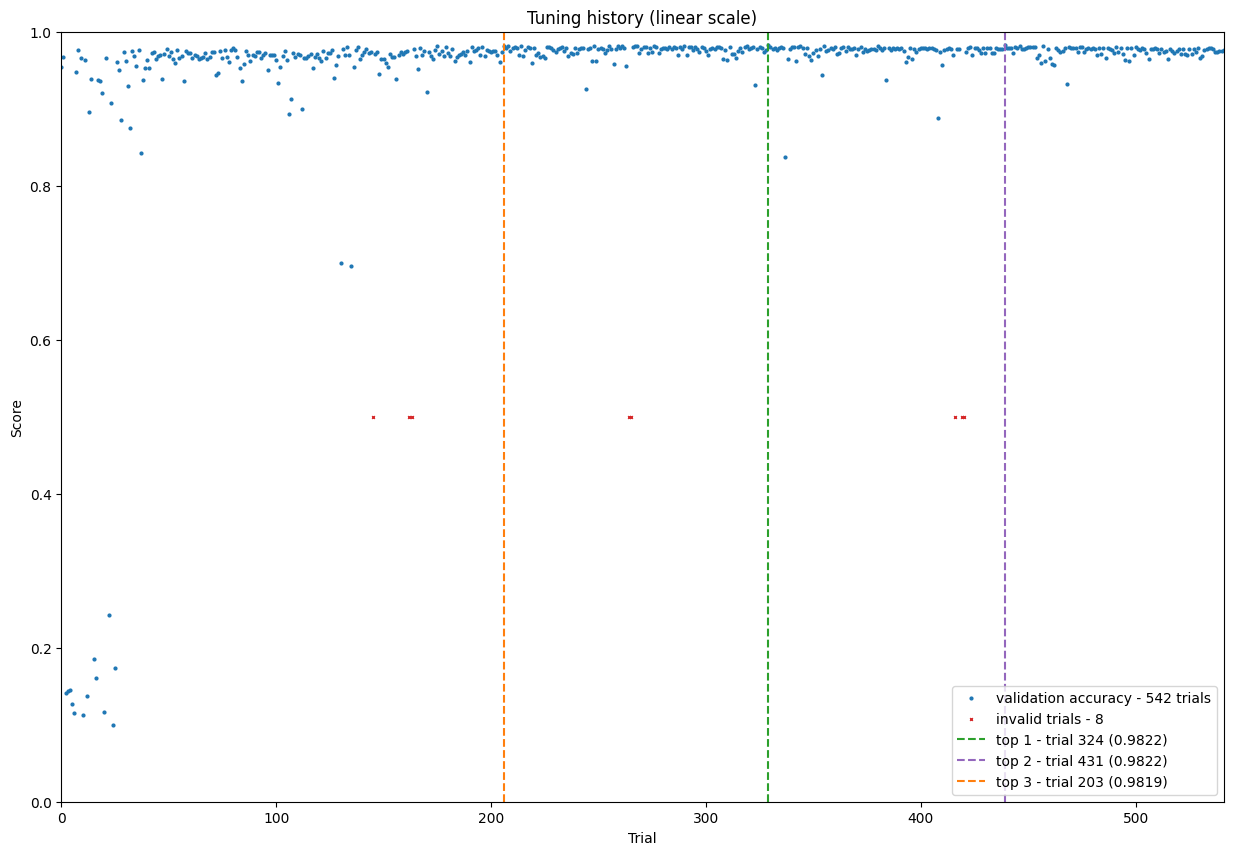

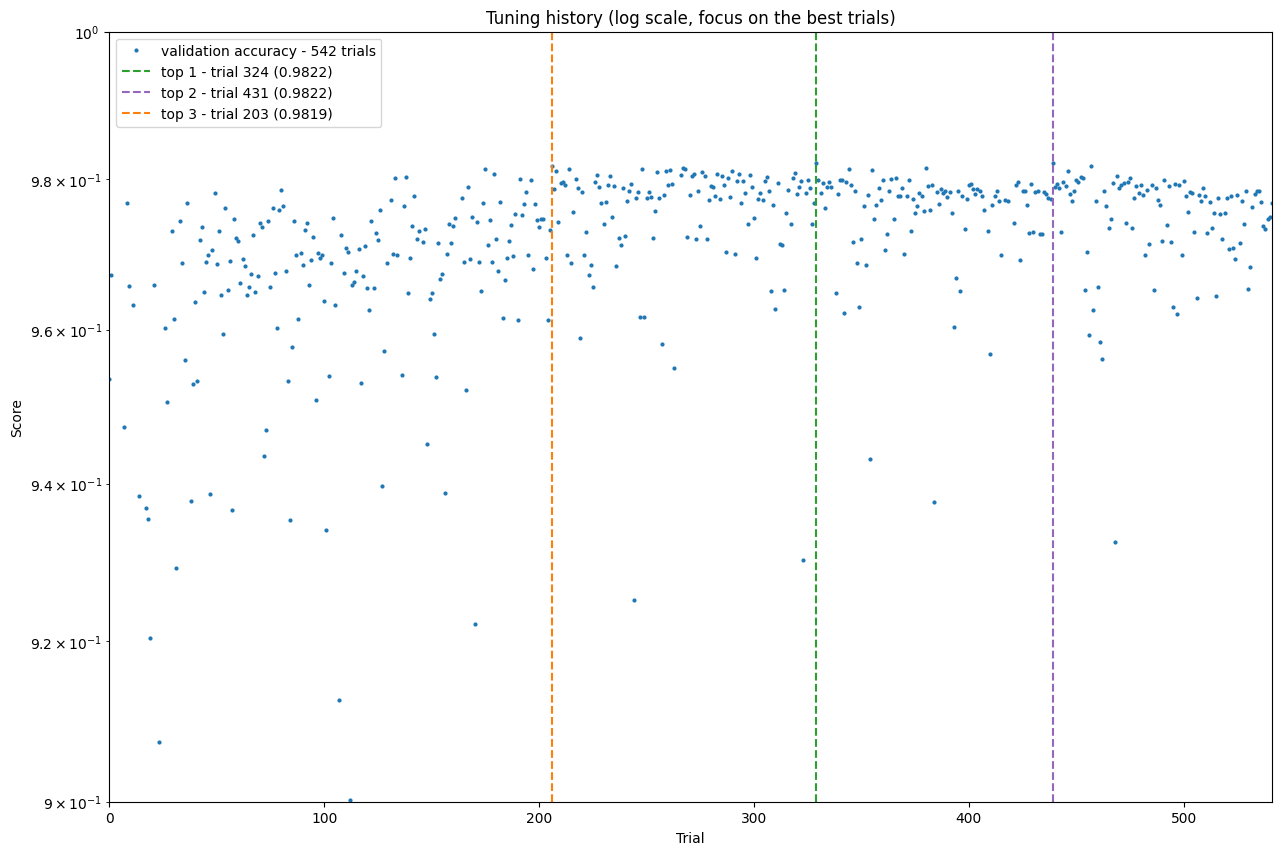

In [76]:
def plot_tuning_trials(
    valid_trials: np.ndarray,
    val_accuracy: np.ndarray,
    invalid_trials: np.ndarray,
    log: bool = False,
):
    # sort validation accuracy
    sorted_val_accuracy_indexes, sorted_val_accuracy, _ = sort_tuning_data(val_accuracy)

    # select the color for the 3 best trials
    best_colors = [
        "tab:green",
        "tab:purple",
        "tab:orange",
    ]

    # plot the scores
    plt.figure(figsize=RECT_FIG_SIZE)
    plt.plot(
        valid_trials,
        val_accuracy,
        label=f"validation accuracy - {len(valid_trials)} trials",
        color="tab:blue",
        marker="o",
        linestyle=" ",
        markersize=2,
    )
    if not log:
        plt.plot(
            invalid_trials,
            np.full(len(invalid_trials), 0.5),
            label=f"invalid trials - {len(invalid_trials)}",
            color="tab:red",
            marker="x",
            linestyle=" ",
            markersize=2,
        )

    # plot the best trials
    for x, c in enumerate(best_colors):
        label = (
            f"top {x + 1} - trial {sorted_val_accuracy_indexes[x]} "
            f"({sorted_val_accuracy[x]:.4f})"
        )
        plt.axvline(
            valid_trials[sorted_val_accuracy_indexes[x]],
            label=label,
            linestyle="--",
            color=c,
        )

    plt.xlabel("Trial")
    plt.ylabel("Score")
    plt.xlim(0, len(val_accuracy) - 1)

    if log:
        plt.yscale("log")
        plt.title("Tuning history (log scale, focus on the best trials)")
        plt.ylim(0.9, 1)
    else:
        plt.title("Tuning history (linear scale)")
        plt.ylim(0, 1)

    plt.legend()
    plt.show()


# plot the tuning trials
plot_tuning_trials(valid_trials, val_accuracy, invalid_trials)
# plot the tuning trials with log scale
plot_tuning_trials(valid_trials, val_accuracy, invalid_trials, log=True)

#### Plot the distribution of the tuning results


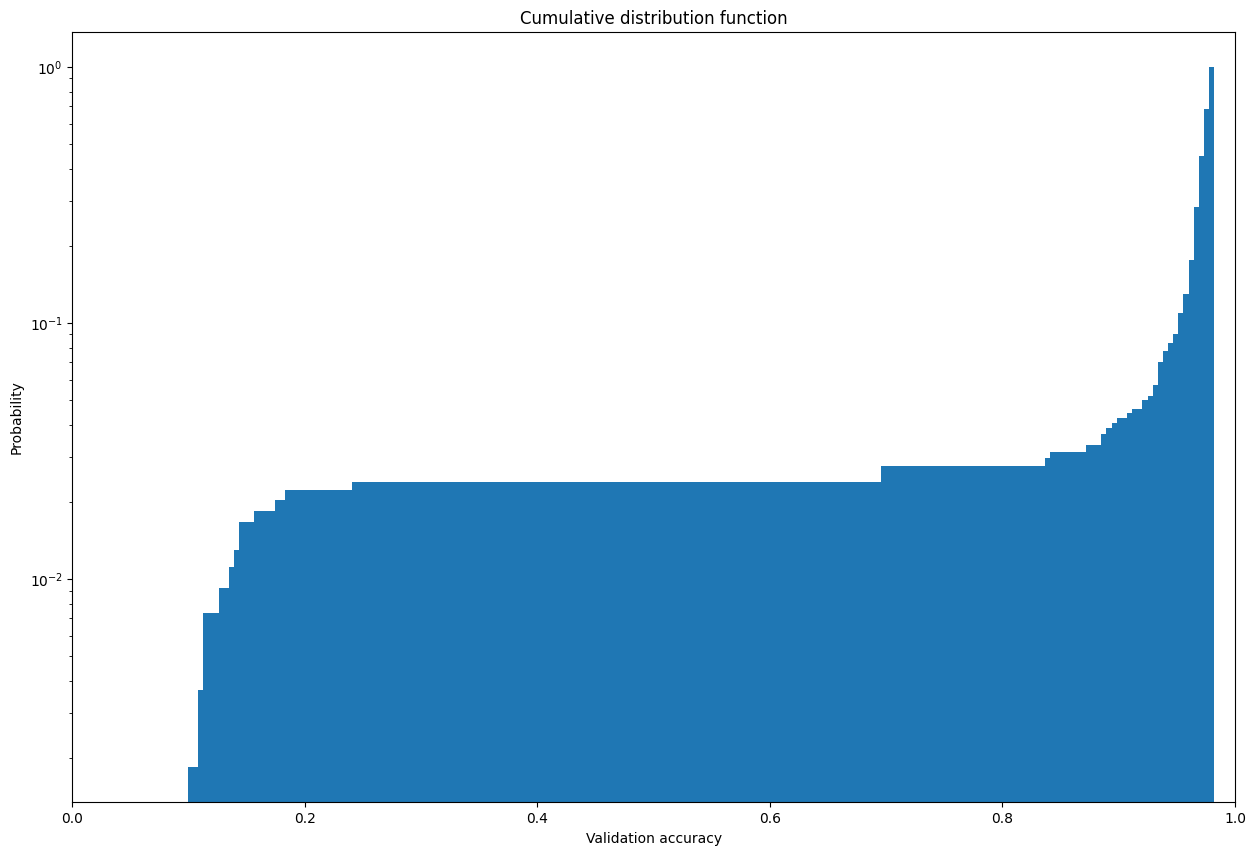

In [77]:
# plot cumulative distribution function
plt.figure(figsize=RECT_FIG_SIZE)
plt.hist(
    val_accuracy,
    cumulative=True,
    density=True,
    bins=200,
    color="tab:blue",
    log=True,
)
plt.xlim(0, 1)
plt.xlabel("Validation accuracy")
plt.ylabel("Probability")
plt.title("Cumulative distribution function")
plt.show()

#### Show the best and worst models


In [78]:
def print_header(headers: list[str], columns_width: list[int]) -> None:
    # row top
    print("┏", end="")
    for x, w in enumerate(columns_width):
        if x == len(columns_width) - 1:
            print("━" * (w - 1) + "┓")
        else:
            print("━" * (w - 1) + "┳", end="")
    # header names
    print(f"┃ {' ┃ '.join(headers)} ┃")
    # row bottom
    print("┡", end="")
    for x, w in enumerate(columns_width):
        if x == len(columns_width) - 1:
            print("━" * (w - 1) + "┩")
        else:
            print("━" * (w - 1) + "╇", end="")


def print_line(values: list[str], columns_width: list[int], last: bool = False) -> None:
    # calculate the spacing for each column
    spacings = []
    for y, v in enumerate(values):
        spacing_left = (columns_width[y] - len(str(v))) // 2 - 1
        spacing_right = columns_width[y] - len(str(v)) - spacing_left - 1

        if spacing_left < spacing_right:
            spacing_left += 1
            spacing_right -= 1

        spacings.append((" " * spacing_left, " " * spacing_right))

    # row content
    for y, v in enumerate(values):
        left, right = spacings[y]
        print(f"│{left}{v}{right}", end="")
    print("│")

    # row bottom
    if last:
        print("└", end="")
        for y, w in enumerate(columns_width):
            if y == len(columns_width) - 1:
                print("─" * (w - 1) + "┘")
            else:
                print("─" * (w - 1) + "┴", end="")
    else:
        print("├", end="")
        for y, w in enumerate(columns_width):
            if y == len(columns_width) - 1:
                print("─" * (w - 1) + "┤")
            else:
                print("─" * (w - 1) + "┼", end="")


def show_table(headers: list[str], values: list[list[str]]) -> None:
    # get the width of each column
    columns_width = [len(header) + 3 for header in headers]

    print_header(headers, columns_width)

    # print the values
    for x, line in enumerate(values):
        last = x == len(values) - 1
        print_line(line, columns_width, last=last)


def create_header_MD(headers: list[str], columns_width: list[int]) -> str:
    # row top
    # header names
    out = f"| {' | '.join(headers)} |" + "\n"
    # row bottom
    out += "|"
    for w in columns_width:
        out += f":{'─' * (w - 3)}:|"

    out += "\n"
    return out


def create_line_MD(values: list[str], columns_width: list[int]) -> str:
    # calculate the spacing for each column
    spacings = []
    for y, v in enumerate(values):
        spacing_left = (columns_width[y] - len(str(v))) // 2 - 1
        spacing_right = columns_width[y] - len(str(v)) - spacing_left - 1

        if spacing_left < spacing_right:
            spacing_left += 1
            spacing_right -= 1

        spacings.append((" " * spacing_left, " " * spacing_right))

    # row content
    out = ""
    for y, v in enumerate(values):
        left, right = spacings[y]
        out += f"|{left}{v}{right}"
    out += "|"
    return out


def create_table_MD(headers: list[str], values: list[list[str]]) -> str:
    # get the width of each column
    columns_width = [len(header) + 3 for header in headers]

    header = create_header_MD(headers, columns_width)
    lines = [create_line_MD(line, columns_width) for line in values]
    return header + "\n".join(lines)


# number of best and worst hyperparameters to show
N = 10
hyperparameters_names = ["trial #", "val_accuracy"] + list(
    hyperparameter_values[0].keys()
)

# sort the hyperparameters by validation accuracy
(
    sorted_val_accuracy_indexes,
    sorted_val_accuracy,
    sorted_hyperparameters,
) = sort_tuning_data(
    val_accuracy,
    hyperparameter_values,
)

best_hyperparameter_values = [list(x.values()) for x in sorted_hyperparameters[:N]]
for x in range(N):
    best_hyperparameter_values[x].insert(0, f"{sorted_val_accuracy[x]:.4f}")
    best_hyperparameter_values[x].insert(0, f"{sorted_val_accuracy_indexes[x]}")

worst_hyperparameter_values = [list(x.values()) for x in sorted_hyperparameters[-N:]][
    ::-1
]
for x in range(N):
    worst_hyperparameter_values[x].insert(0, f"{sorted_val_accuracy[-x-1]:.4f}")
    worst_hyperparameter_values[x].insert(0, f"{sorted_val_accuracy_indexes[-x-1]}")

##### Best models


In [79]:
show_table(hyperparameters_names, best_hyperparameter_values)

┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ trial # ┃ val_accuracy ┃ conv_1_filters ┃ conv_2_filters ┃ conv_3_filters ┃ conv_1_kernels ┃ conv_2_kernels ┃ conv_3_kernels ┃ dense_1_units ┃ dense_2_units ┃ optimizer ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│   324   │    0.9822    │       256      │       256      │       32       │        7       │        7       │        5       │       64      │       0       │    adam   │
├─────────┼──────────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼───────────────┼───────────┤
│   431   │    0.9822    │       256      │       256      │       32       │        7       │        7       │        7       │      1

##### Worst models


In [80]:
show_table(hyperparameters_names, worst_hyperparameter_values)

┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ trial # ┃ val_accuracy ┃ conv_1_filters ┃ conv_2_filters ┃ conv_3_filters ┃ conv_1_kernels ┃ conv_2_kernels ┃ conv_3_kernels ┃ dense_1_units ┃ dense_2_units ┃ optimizer ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│    24   │    0.0991    │       128      │       32       │       32       │        5       │        3       │        7       │      256      │      512      │  adadelta │
├─────────┼──────────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼───────────────┼───────────┤
│    10   │    0.1121    │       64       │       64       │       64       │        7       │        5       │        3       │       

##### Save best models table (markdown)


In [81]:
with open("best_hyperparameters", "w") as f:
    table = create_table_MD(hyperparameters_names, best_hyperparameter_values)
    f.write(table)

##### Save worst models table (markdown)


In [82]:
with open("worst_hyperparameters", "w") as f:
    table = create_table_MD(hyperparameters_names, worst_hyperparameter_values)
    f.write(table)

### Train model


In [83]:
def train_model(model: tfk.Model, epochs: int) -> tfk.Model:
    # shuffle the training set
    ds_train_shuffled = batched_ds_train.shuffle(len(ds_train))
    min_delta = (
        1e-4  # minimum change in the monitored quantity to qualify as an improvement
    )
    min_lr = 1e-7  # minimum learning rate

    # create the early stopping callback
    early_stopping = tfk.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        min_delta=min_delta,
    )
    reduce_lr = tfk.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=4,
        min_lr=min_lr,
        min_delta=min_delta,
    )
    checkpoint = tfk.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        monitor="val_loss",
        save_best_only=False,
        save_weights_only=False,
    )

    # show the model summary
    model.summary()

    # train the model
    model.fit(
        ds_train_shuffled,
        validation_data=batched_ds_validation,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        class_weight=class_weights,
    )

    return model


if os.path.exists(TRAINED_MODEL_PATH) and LOAD_TRAINED_MODEL:
    print("Loading trained model")
    trained_model = tfk.models.load_model(TRAINED_MODEL_PATH)
    print("Loading training history")
    trained_model_history = np.load(
        f"{TRAINED_MODEL_PATH}-history.npy", allow_pickle=True
    ).item()
else:
    print("Training model")
    trained_model = train_model(tuned_model, MAX_EPOCHS)
    print("Saving trained model")
    trained_model.save(TRAINED_MODEL_PATH)
    print("Saving training history")

    # save as numpy array, because json does not support numpy arrays
    trained_model_history = trained_model.history.history
    np.save(f"{TRAINED_MODEL_PATH}-history.npy", trained_model_history)

Loading trained model


Loading training history


#### Plot training history


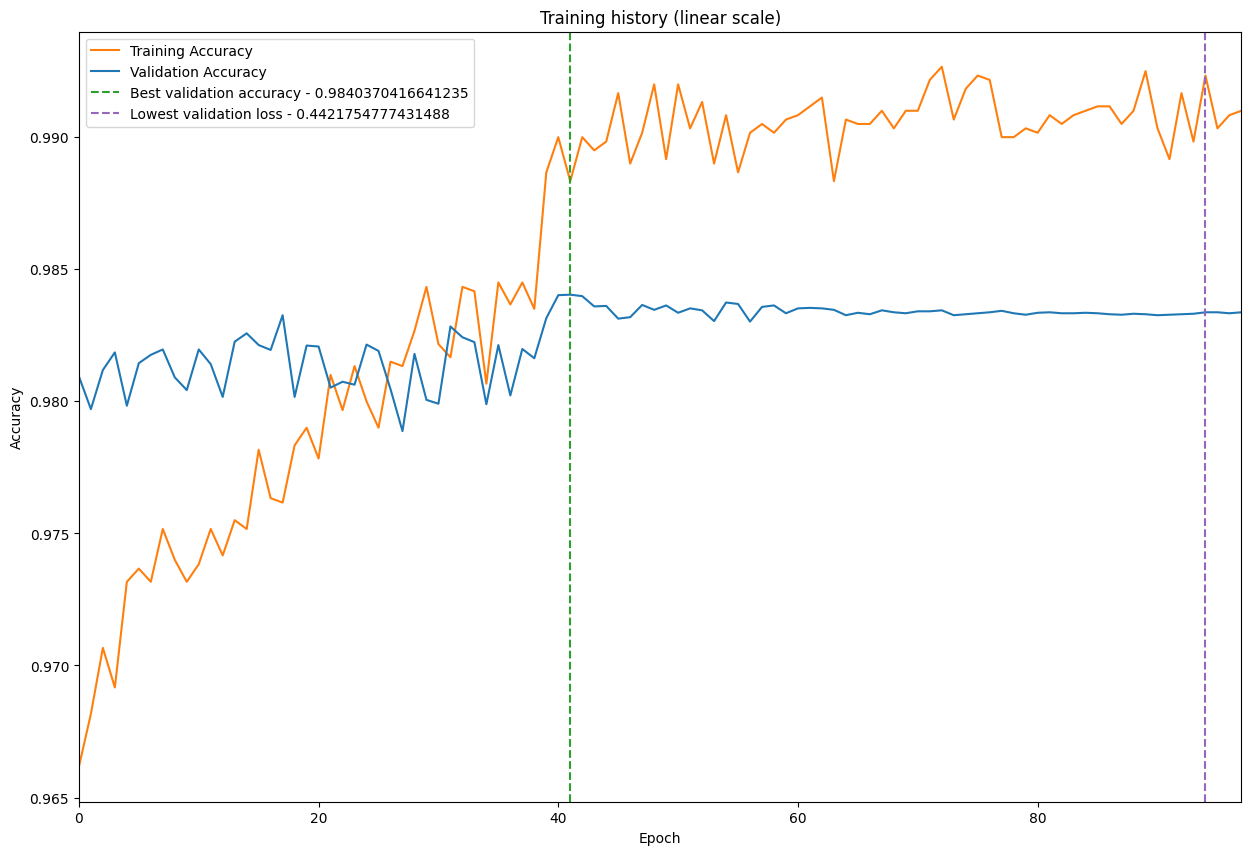

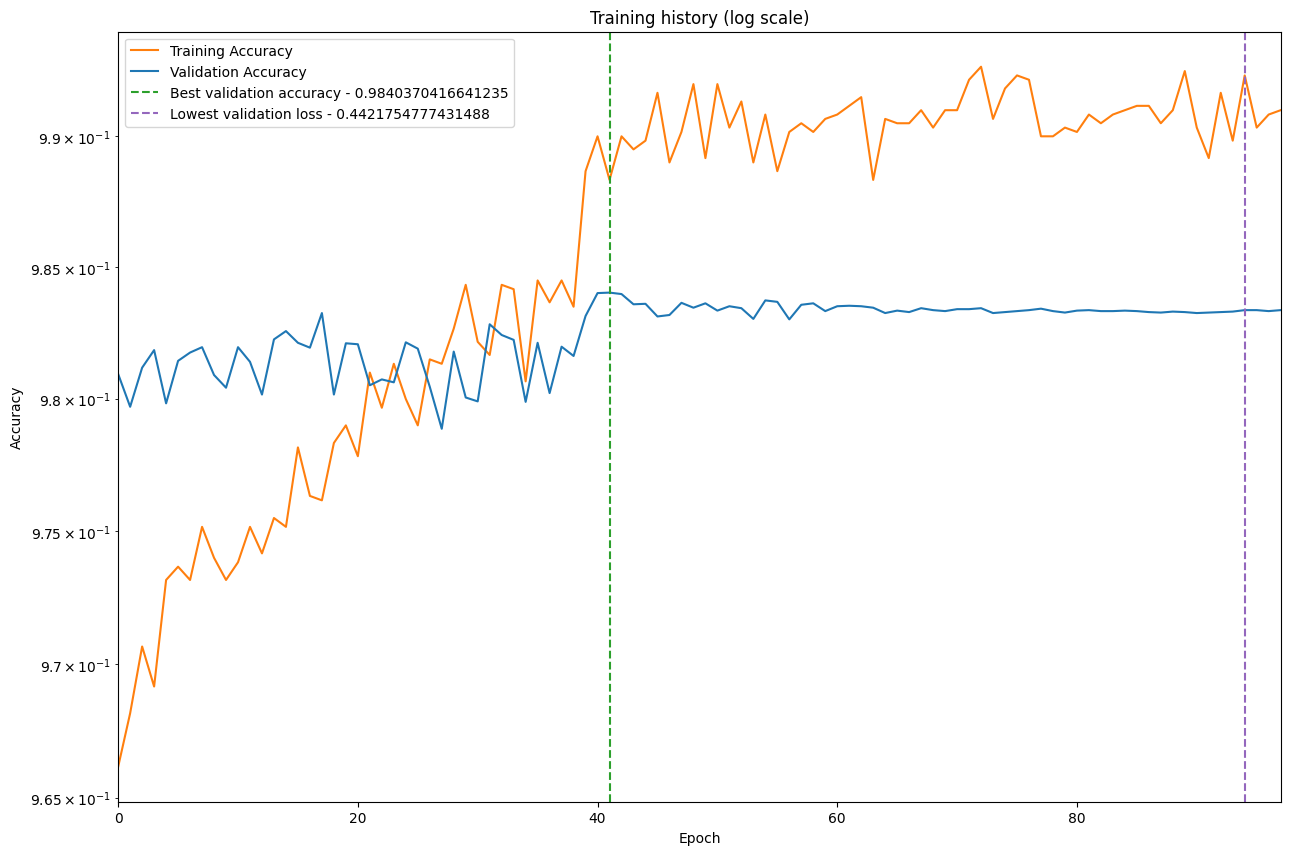

In [84]:
def plot_history(
    history: dict,
    size: tuple[int, int] = RECT_FIG_SIZE,
    log: bool = False,
) -> None:
    plt.figure(figsize=size)
    plt.plot(
        history["sparse_categorical_accuracy"],
        label="Training Accuracy",
        color="tab:orange",
    )
    plt.plot(
        history["val_sparse_categorical_accuracy"],
        label="Validation Accuracy",
        color="tab:blue",
    )

    best_accuracy = np.max(history["val_sparse_categorical_accuracy"])
    best_accuracy_epoch = np.argmax(history["val_sparse_categorical_accuracy"])
    plt.axvline(
        best_accuracy_epoch,
        label=f"Best validation accuracy - {best_accuracy}",
        color="tab:green",
        linestyle="--",
    )

    lowest_loss = np.min(history["val_loss"])
    lowest_loss_epoch = np.argmin(history["val_loss"])
    plt.axvline(
        lowest_loss_epoch,
        label=f"Lowest validation loss - {lowest_loss}",
        color="tab:purple",
        linestyle="--",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xlim(0, len(history["sparse_categorical_accuracy"]) - 1)

    if log:
        plt.yscale("log")
        plt.title("Training history (log scale)")
    else:
        plt.title("Training history (linear scale)")

    plt.legend()
    plt.show()


plot_history(trained_model_history)
plot_history(trained_model_history, log=True)

#### Show model matrices and weights


conv_1


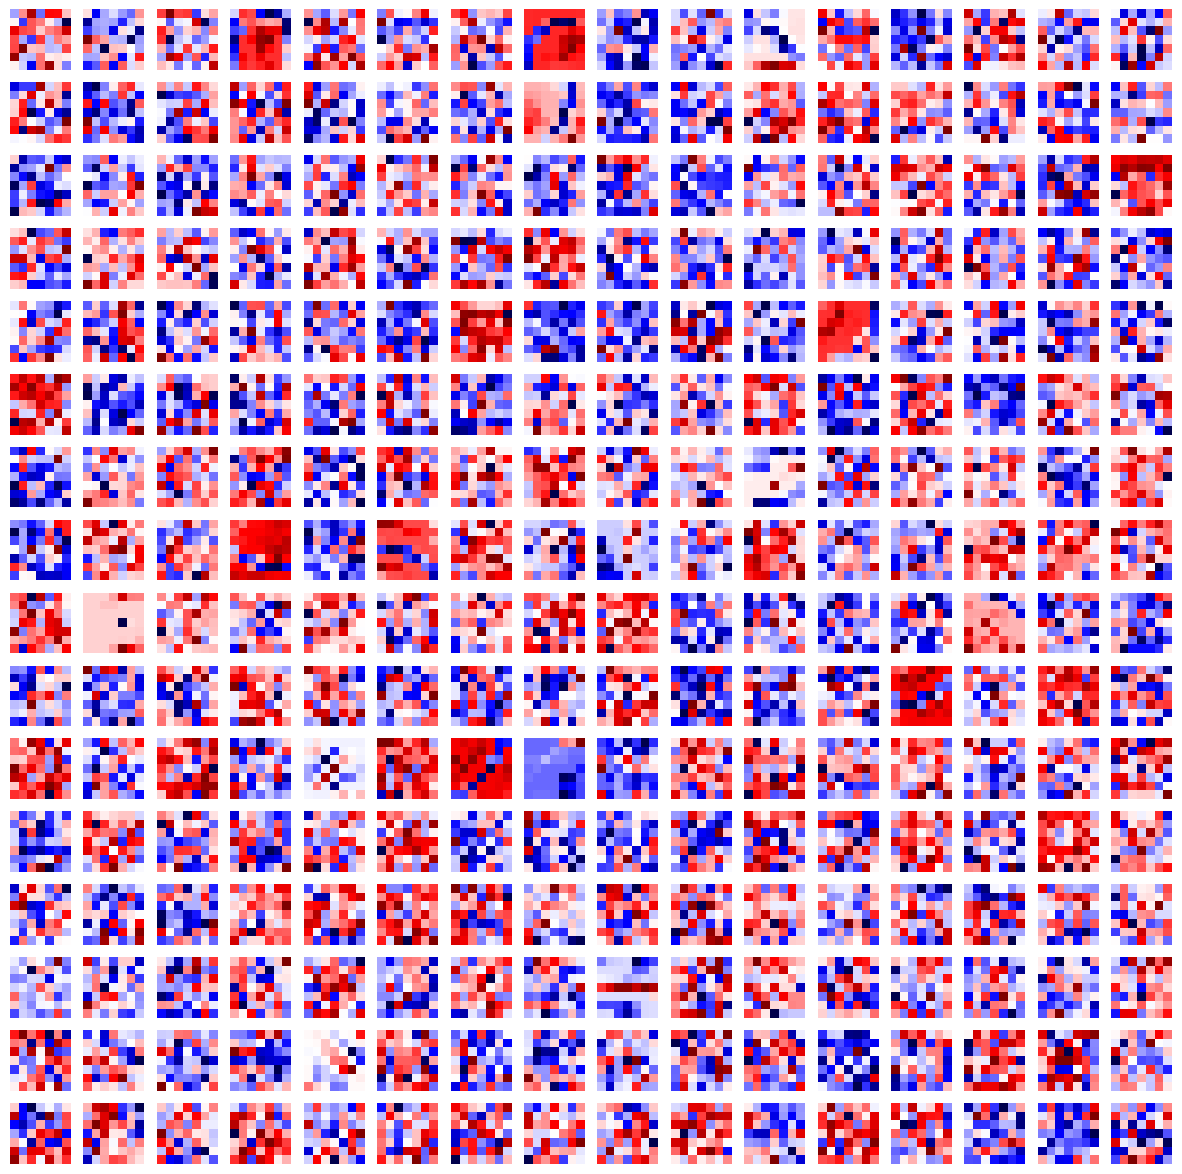

conv_2


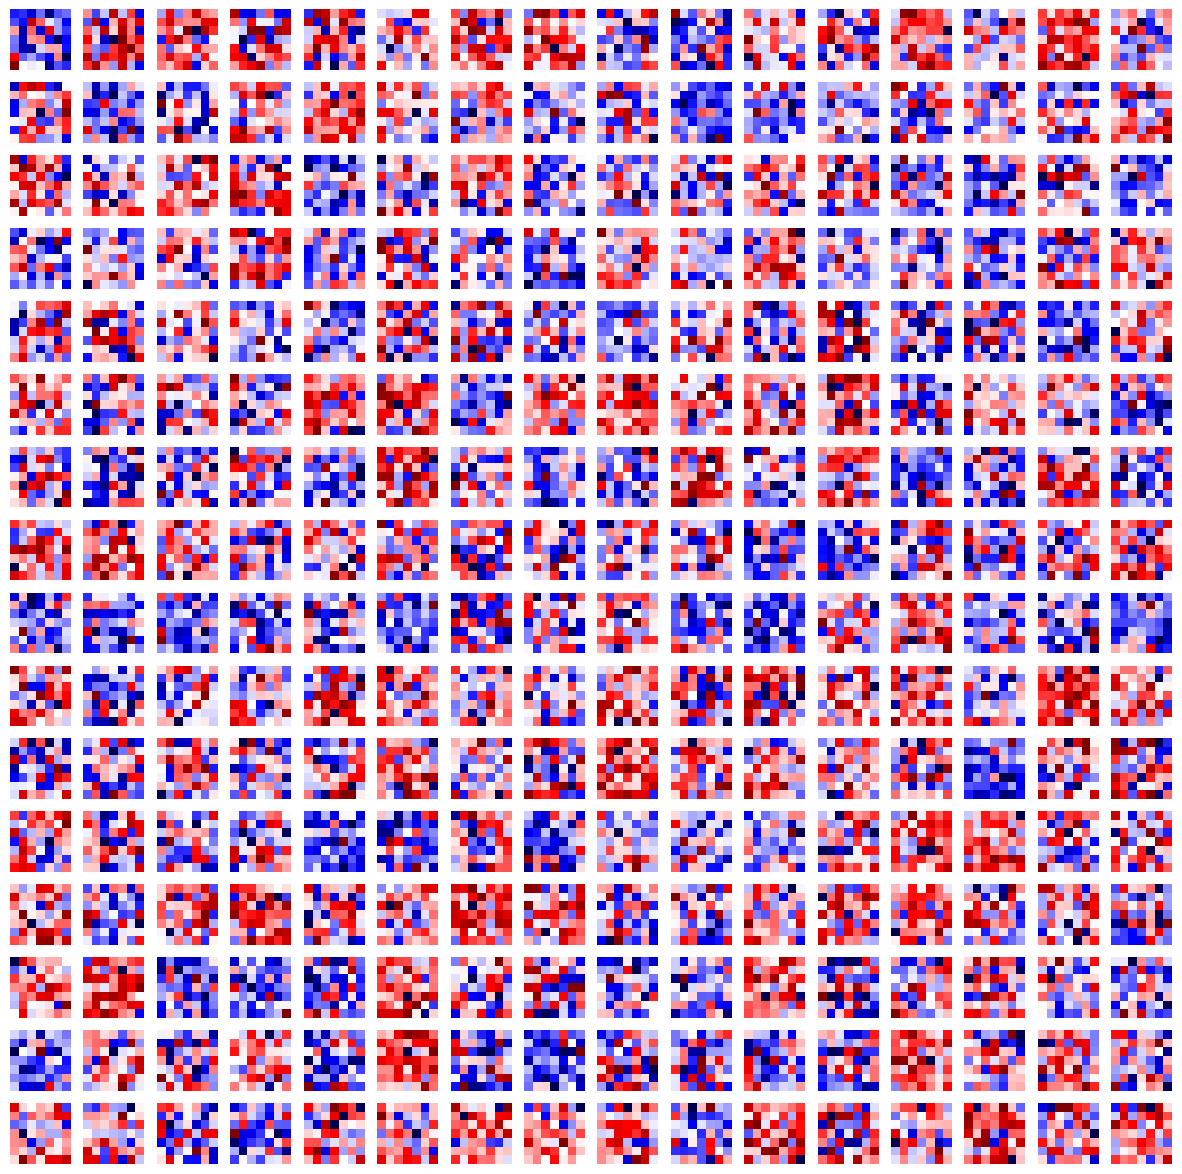

conv_3


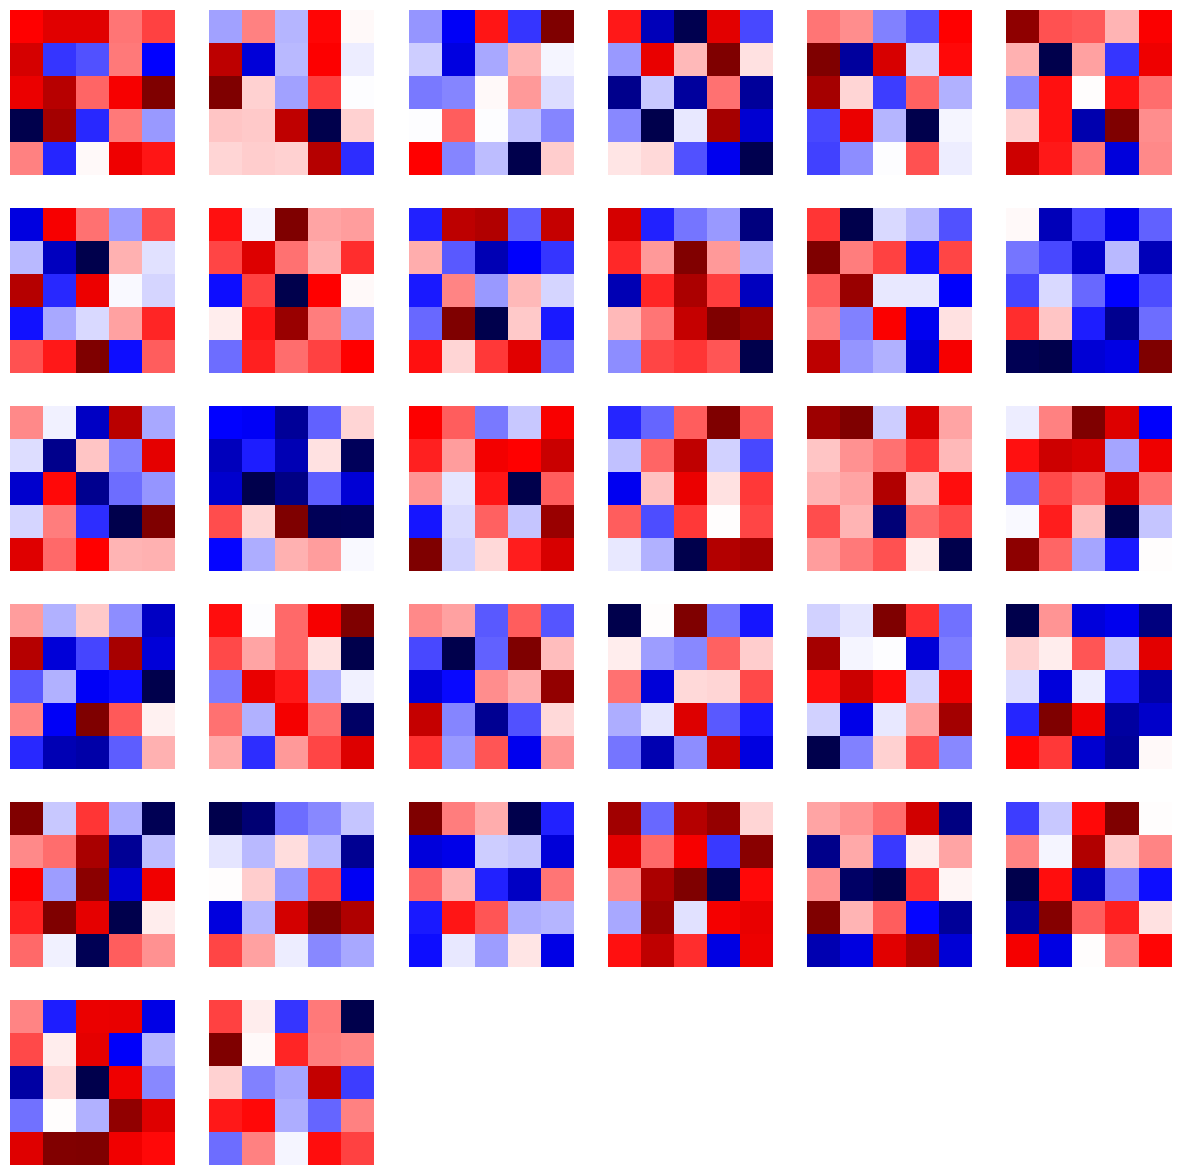

dense_1


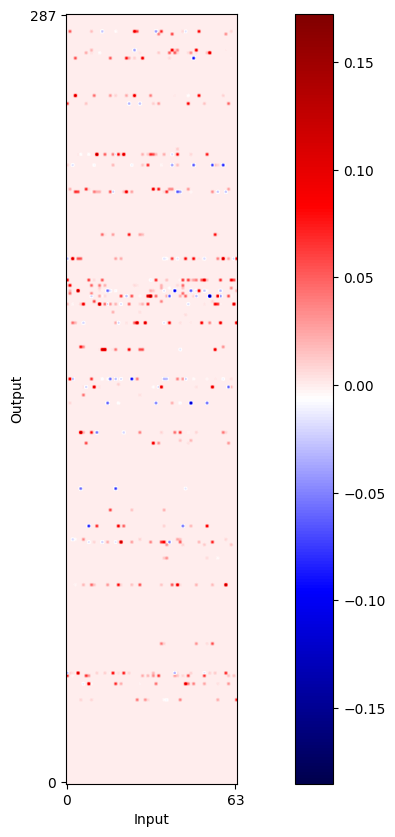

dense_out


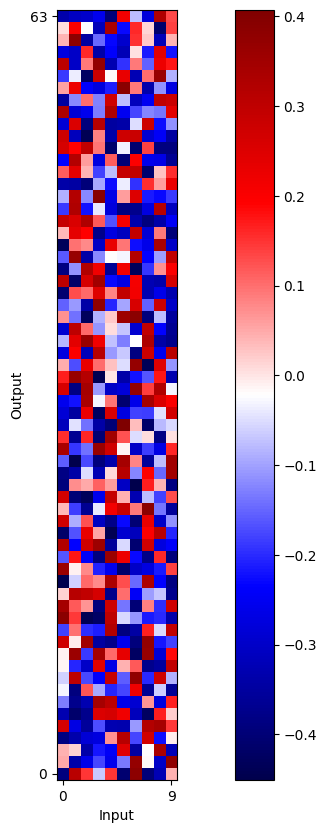

In [85]:
def show_conv_weights(
    filters: np.ndarray,
    title: str,
):
    side = int(np.ceil(np.sqrt(filters.shape[-1])))
    _, axs = plt.subplots(side, side, figsize=SQUARE_FIG_SIZE)

    for i in range(filters.shape[-1]):
        f = filters[:, :, :, i]
        row = i // side
        col = i % side

        axs[row, col].imshow(f[:, :, 0], cmap="seismic")
        axs[row, col].axis("off")

    for i in range(filters.shape[-1], side**2):
        row = i // side
        col = i % side
        axs[row, col].axis("off")

    print(title)
    plt.show()


def show_dense_weights(
    weights: np.ndarray,
    title: str,
):
    plt.figure(figsize=RECT_FIG_SIZE)
    plt.imshow(weights, cmap="seismic")
    plt.xticks((0, weights.shape[1] - 1))
    plt.yticks((0, weights.shape[0] - 1))
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.gca().invert_yaxis()
    plt.colorbar()

    print(title)
    plt.show()


for layer in trained_model.layers:
    if "conv" in layer.name:
        weights, bias = layer.get_weights()
        show_conv_weights(weights, layer.name)
    elif "dense" in layer.name:
        weights, bias = layer.get_weights()
        show_dense_weights(weights, layer.name)

## Evaluation section


### Evaluate model on test data


In [86]:
def predict(model: tfk.Model, ds: tf.data.Dataset) -> tuple[np.ndarray]:
    probabilities = model.predict(ds)
    prediction = np.argmax(probabilities, axis=1)
    labels = np.concatenate([y.numpy() for _, y in ds], axis=0)
    return labels, prediction, probabilities


labels, predictions, probabilities = predict(trained_model, batched_ds_test)

422/422 [==============================] - 9s 21ms/step


### Show metrics


In [87]:
def calculate_metrics(prediction: np.ndarray, labels: np.ndarray) -> tuple[float]:
    accuracy = accuracy_score(labels, prediction)
    precision = precision_score(labels, prediction, average="macro")
    recall = recall_score(labels, prediction, average="macro")
    f1 = f1_score(labels, prediction, average="macro")
    return accuracy, precision, recall, f1


accuracy, precision, recall, f1 = calculate_metrics(predictions, labels)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: 0.9832777777777778
Precision: 0.9832502222742707
Recall: 0.9832964008671585
F1: 0.9832618611168126


### Show confusion matrix


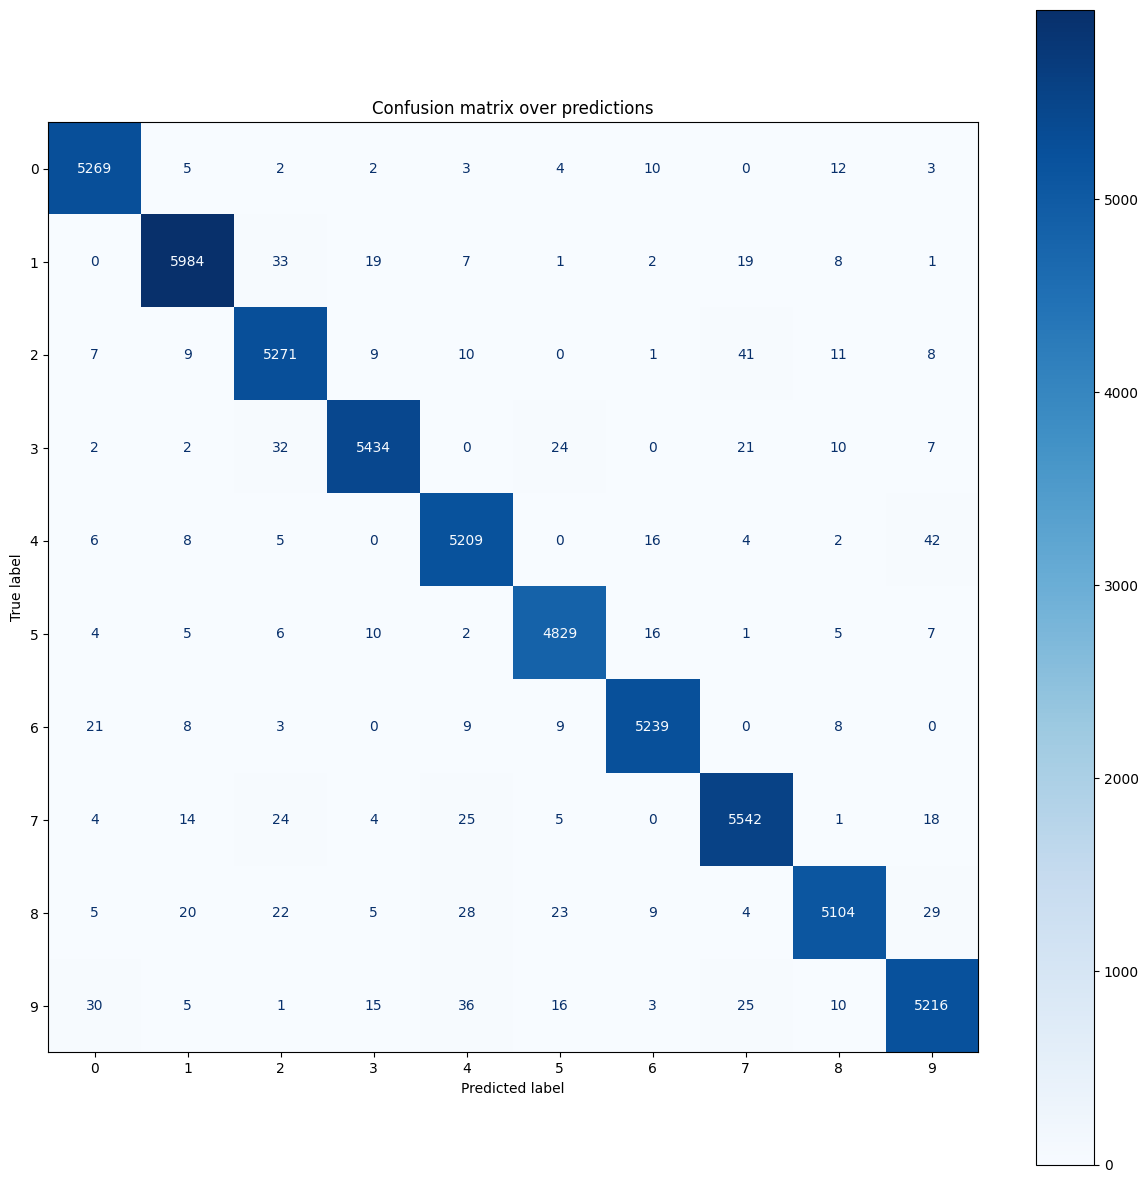

In [88]:
def plot_confusion_matrix(
    prediction: np.ndarray,
    labels: np.ndarray,
    size: tuple[int, int] = SQUARE_FIG_SIZE,
) -> None:
    _, ax = plt.subplots(figsize=size)
    ConfusionMatrixDisplay.from_predictions(labels, prediction, ax=ax, cmap="Blues")
    plt.title("Confusion matrix over predictions")
    plt.show()


plot_confusion_matrix(predictions, labels)

### Show some predictions


In [89]:
def extract(
    dataset: tf.data.Dataset,
    predictions: np.ndarray,
    probabilities: np.ndarray,
) -> tuple[dict, dict]:
    images = {True: [], False: []}
    labels = {True: [], False: []}
    predicted_labels = {True: [], False: []}
    predicted_probabilities = {True: [], False: []}

    for i, (image, label) in enumerate(dataset):
        correct = predictions[i] == label.numpy()
        images[correct].append(image.numpy().squeeze())
        labels[correct].append(label.numpy())
        predicted_labels[correct].append(predictions[i])
        predicted_probabilities[correct].append(probabilities[i])

    return (
        images[True],
        labels[True],
        predicted_labels[True],
        predicted_probabilities[True],
    ), (
        images[False],
        labels[False],
        predicted_labels[False],
        predicted_probabilities[False],
    )


def plot_predictions(
    images: list[np.ndarray],
    predictions: list[int],
    labels: list[int],
    size: tuple[int, int] = SQUARE_FIG_SIZE,
):
    # shuffle the indexes
    indexes = np.arange(len(images))
    np.random.shuffle(indexes)
    # take the first 25 images
    images = np.array(images)[indexes][:25]
    predictions = np.array(predictions)[indexes][:25]
    labels = np.array(labels)[indexes][:25]

    plt.figure(figsize=size)
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Predicted: {predictions[i]}, True: {labels[i]}")
        plt.axis("off")

    plt.show()


# extract correct and incorrect predictions
correct_data, incorrect_data = extract(
    ds_test,
    predictions,
    probabilities,
)

# unpack the data
(
    correct_images,
    correct_labels,
    correct_predictions,
    correct_probabilities,
) = correct_data
(
    incorrect_images,
    incorrect_labels,
    incorrect_predictions,
    incorrect_probabilities,
) = incorrect_data

#### Correct predictions


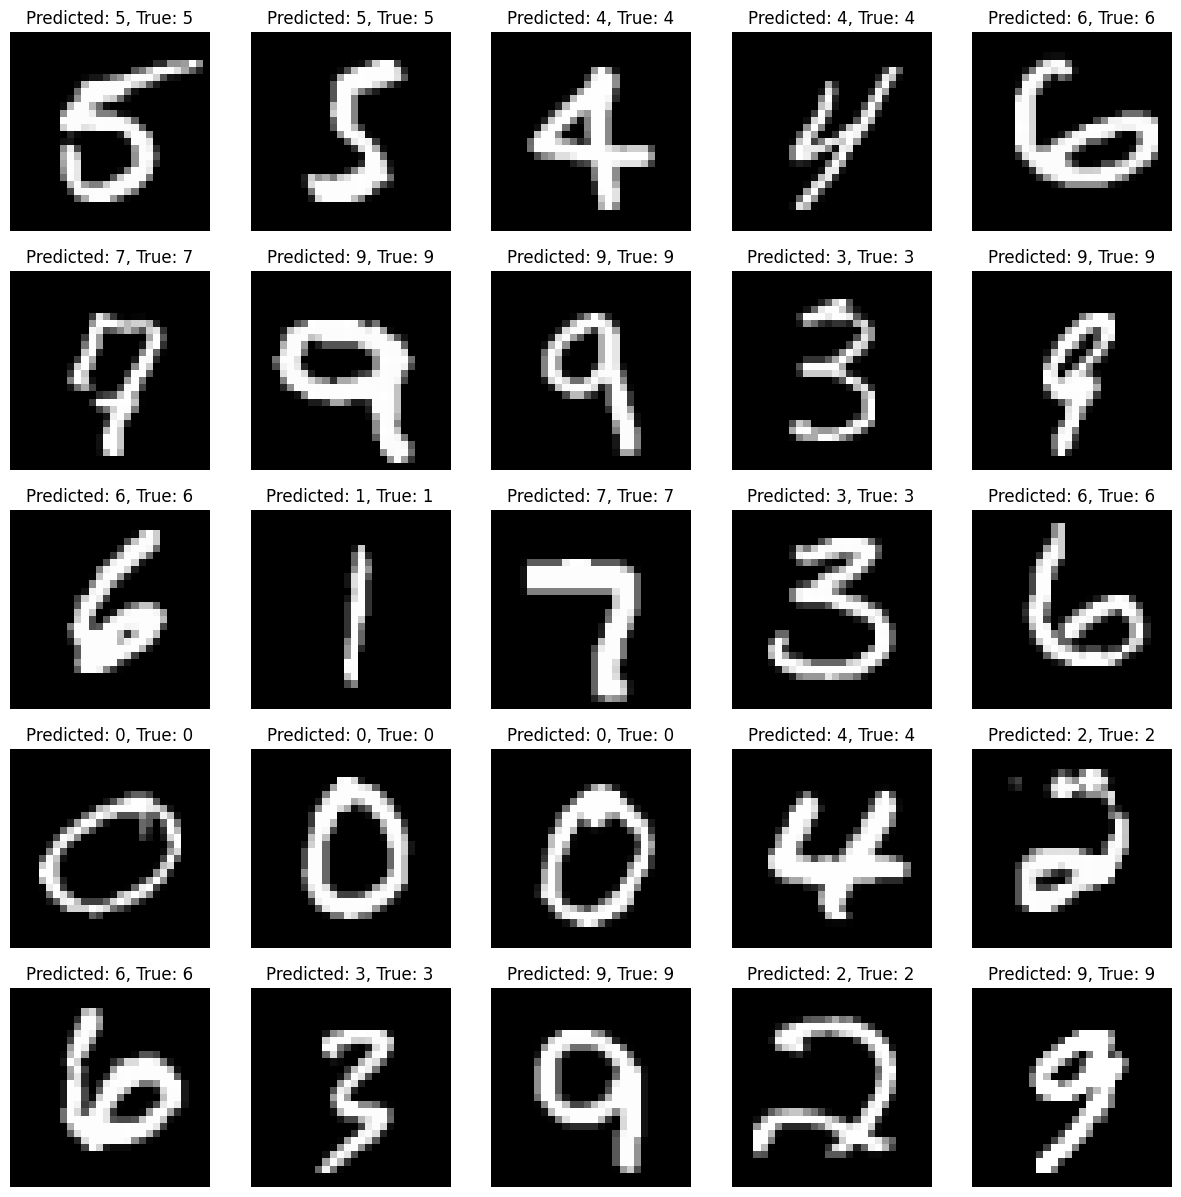

In [90]:
plot_predictions(correct_images, correct_predictions, correct_labels)

#### Incorrect predictions


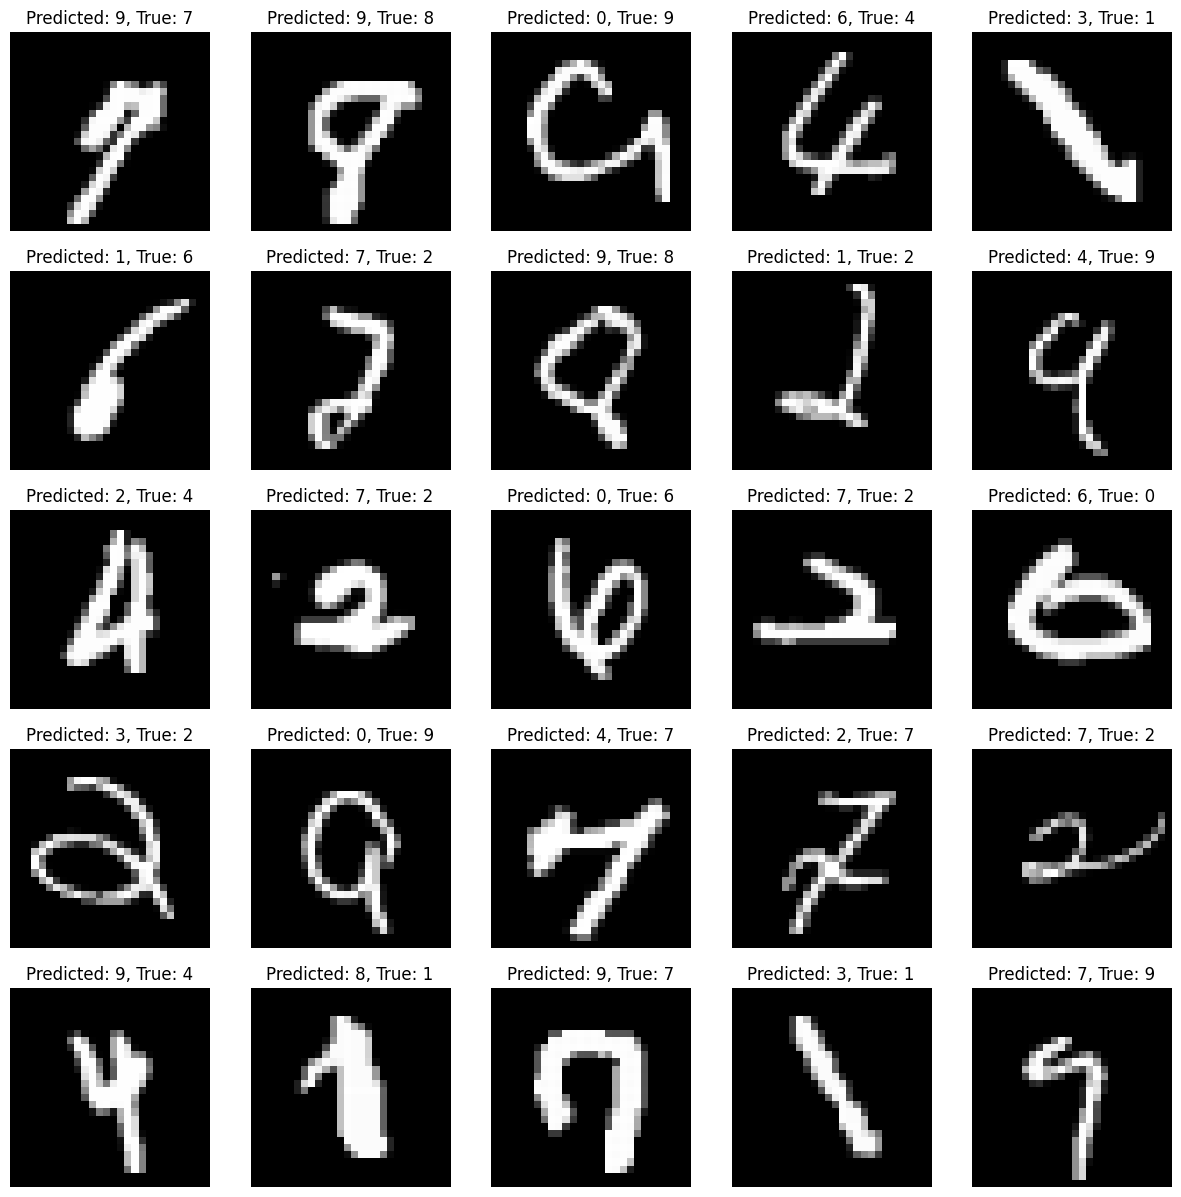

In [91]:
plot_predictions(incorrect_images, incorrect_predictions, incorrect_labels)

### Show probability of predictions


In [92]:
def plot_prediction_probability(
    image: np.ndarray,
    label: int,
    prediction: int,
    probabilities: np.ndarray,
):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted: {prediction}, True: {label}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.bar(range(10), probabilities)
    plt.xticks(range(10))
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title("Probabilities")
    plt.show()

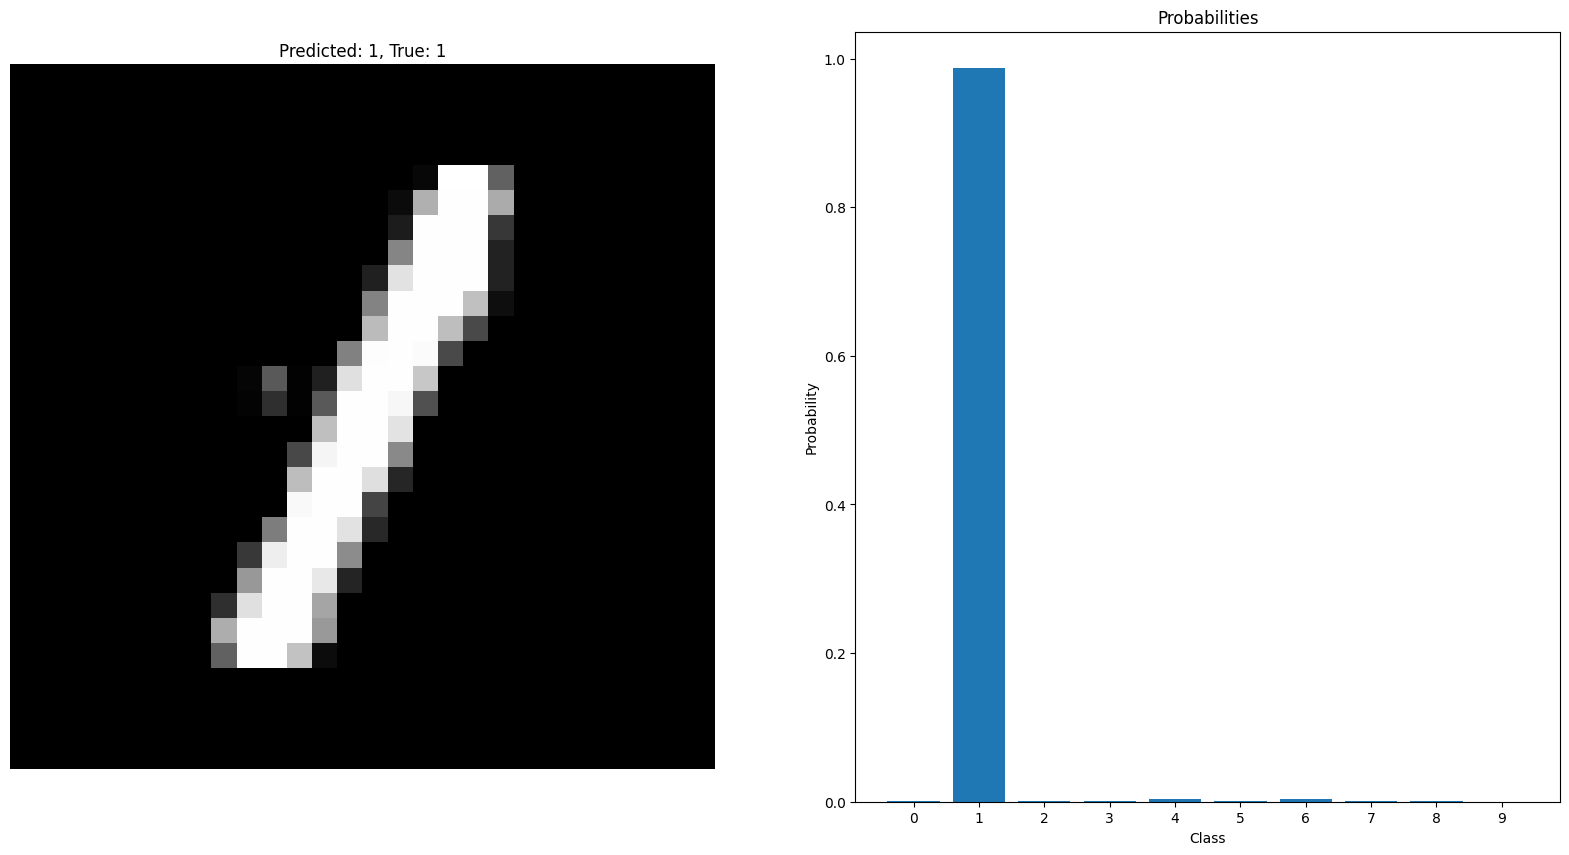

In [93]:
# pick a random correct prediction
index = np.random.randint(len(correct_images))
image = correct_images[index]
label = correct_labels[index]
prediction = correct_predictions[index]
probabilities = correct_probabilities[index]
plot_prediction_probability(image, label, prediction, probabilities)

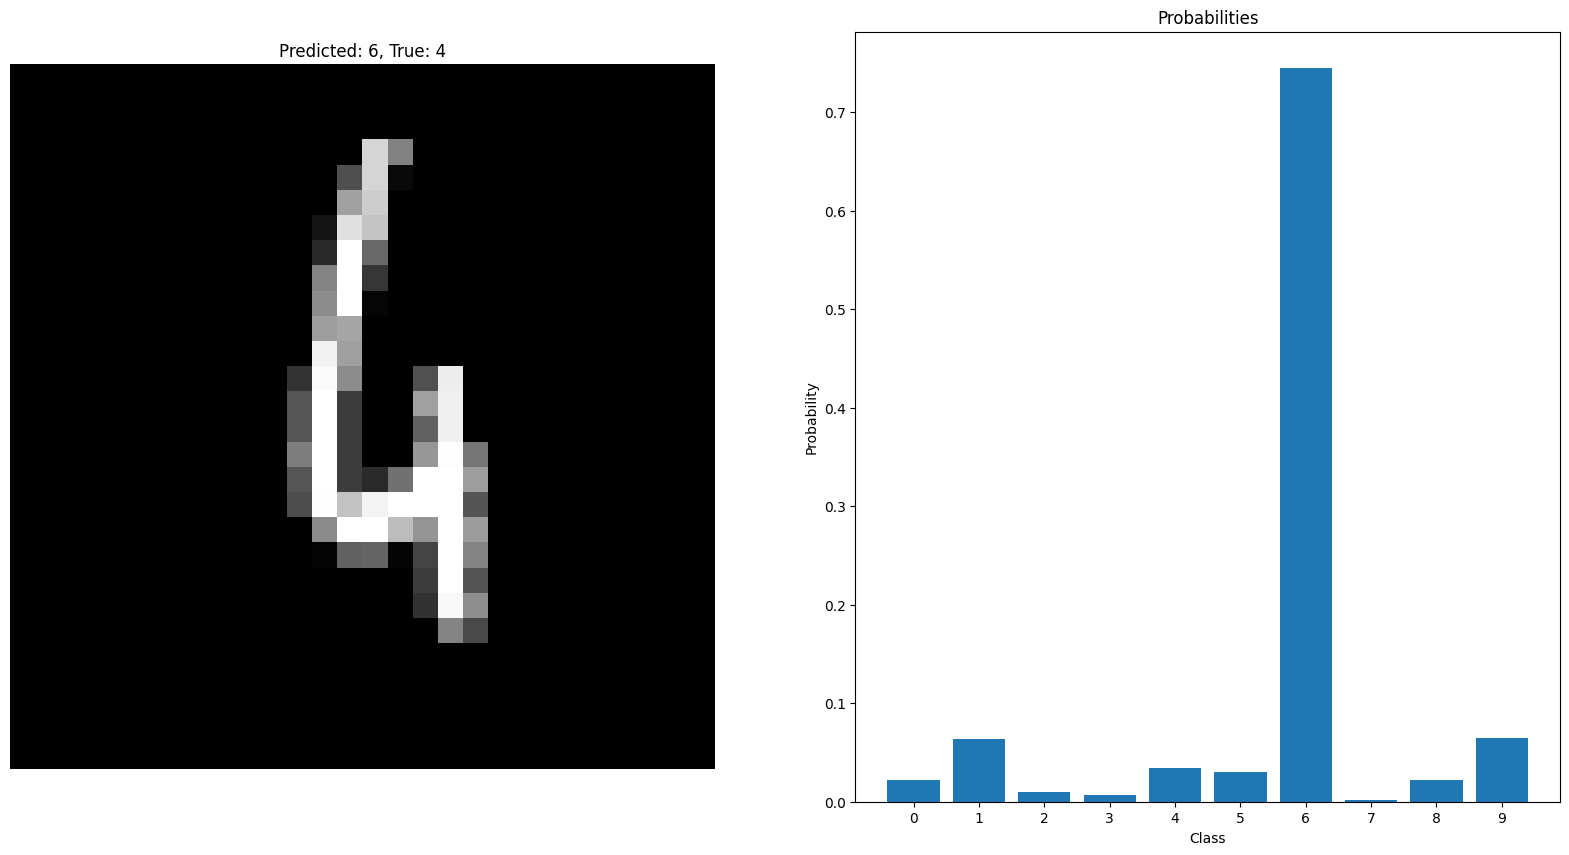

In [94]:
# pick a random incorrect prediction
index = np.random.randint(len(incorrect_images))
image = incorrect_images[index]
label = incorrect_labels[index]
prediction = incorrect_predictions[index]
probabilities = incorrect_probabilities[index]
plot_prediction_probability(image, label, prediction, probabilities)

## Comparison - fully connected model


### Fully connected model creation


In [95]:
def create_fc_model() -> tfk.Model:
    model = tfk.Sequential(
        [
            tfk.layers.Input(shape=INPUT_SHAPE, name="input"),
            tfk.layers.Flatten(name="flatten"),
            tfk.layers.Dense(128, activation="relu", name="dense_1"),
            tfk.layers.Dense(64, activation="relu", name="dense_2"),
            tfk.layers.Dense(10, activation="softmax", name="dense_out"),
        ]
    )

    model.compile(
        optimizer=tfk.optimizers.Adam(1e-4),
        loss=tfk.losses.SparseCategoricalCrossentropy(),
        metrics=[tfk.metrics.SparseCategoricalAccuracy()],
    )

    return model

### Fully connected model training


In [96]:
def train_fc_model(model: tfk.Model, epochs: int) -> tfk.Model:
    # shuffle the training set
    ds_train_shuffled = batched_ds_train.shuffle(len(ds_train))
    # create the early stopping callback
    early_stopping = tfk.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        min_delta=1e-4,
    )
    reduce_lr = tfk.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=4,
        min_lr=1e-7,
        min_delta=1e-4,
    )
    # train the model
    model.fit(
        ds_train_shuffled,
        validation_data=batched_ds_validation,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights,
    )

    return model


if os.path.exists(TRAINED_FC_MODEL_PATH) and LOAD_TRAINED_MODEL:
    print("Loading trained fully connected model")
    trained_fc_model = tfk.models.load_model(TRAINED_FC_MODEL_PATH)
    print("Loading training history")
    trained_fc_model_history = np.load(
        f"{TRAINED_FC_MODEL_PATH}-history.npy", allow_pickle=True
    ).item()
else:
    print("Training fully connected model")
    trained_fc_model = train_fc_model(create_fc_model(), MAX_EPOCHS)
    print("Saving trained fully connected model")
    trained_fc_model.save(TRAINED_FC_MODEL_PATH)
    print("Saving training history")

    # save as numpy array, because json does not support numpy arrays
    trained_fc_model_history = trained_fc_model.history.history
    np.save(f"{TRAINED_FC_MODEL_PATH}-history.npy", trained_fc_model_history)

Training fully connected model
Epoch 1/200


2024-02-05 09:50:27.561503: I external/local_xla/xla/service/service.cc:168] XLA service 0x771ab8d43100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-05 09:50:27.561529: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-02-05 09:50:27.567530: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707123027.626857   23145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 2s 17ms/step - loss: 2.1225 - sparse_categorical_accuracy: 0.3248 - val_loss: 1.9226 - val_sparse_categorical_accuracy: 0.5219 - lr: 1.0000e-04
Epoch 2/200
47/47 [==============================] - 1s 11ms/step - loss: 1.7147 - sparse_categorical_accuracy: 0.6283 - val_loss: 1.4949 - val_sparse_categorical_accuracy: 0.6972 - lr: 1.0000e-04
Epoch 3/200
47/47 [==============================] - 0s 10ms/step - loss: 1.3005 - sparse_categorical_accuracy: 0.7482 - val_loss: 1.1159 - val_sparse_categorical_accuracy: 0.7759 - lr: 1.0000e-04
Epoch 4/200
47/47 [==============================] - 1s 11ms/step - loss: 0.9754 - sparse_categorical_accuracy: 0.8190 - val_loss: 0.8589 - val_sparse_categorical_accuracy: 0.8294 - lr: 1.0000e-04
Epoch 5/200
47/47 [==============================] - 1s 11ms/step - loss: 0.7660 - sparse_categorical_accuracy: 0.8502 - val_loss: 0.6998 - val_sparse_categorical_accuracy: 0.8473 - lr: 1.0000e-04
Epoch 6/200
47/47 [========

### Fully connected model evaluation


In [97]:
fc_labels, fc_predictions, fc_probabilities = predict(trained_fc_model, batched_ds_test)
fc_accuracy, fc_precision, fc_recall, fc_f1 = calculate_metrics(
    fc_predictions, fc_labels
)
fc_improvement = (fc_accuracy - accuracy) / accuracy * 100

print(f"Fully connected model accuracy: {fc_accuracy}")
print(f"Fully connected model precision: {fc_precision}")
print(f"Fully connected model recall: {fc_recall}")
print(f"Fully connected model F1: {fc_f1}")


print(f"Overall improvement in accuracy: {fc_improvement:.2f}%")

422/422 [==============================] - 0s 779us/step
Fully connected model accuracy: 0.9332777777777778
Fully connected model precision: 0.9329079929145735
Fully connected model recall: 0.9325525142297636
Fully connected model F1: 0.9326716334433696
Overall improvement in accuracy: -5.09%
